# 영향력있는거 100개만 쓰기
- 참조: https://github.com/saadbinmanjur/Kaggle-Competition-Santander-Customer-Transaction-Prediction/blob/main/Santander%20Customer%20Transaction%20Prediction.ipynb
- 독립변수: LGBM 의 feature_importance_ 사용해서 영향력 있는 독립변수 100개 뽑음.
- 결측치: 없음
- 이상치: 처리 안함
- 정규화: StandardScaler
- 데이터 불균형: DownSampling_ 타겟이 0인걸 1있는 갯수만큼 랜덤하게 지움
- 모델: GNB (가우시안 나이브 베이즈) 사용_ 상관계수가 전부 낮아서 유리

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# 정규화 (StandardScaler 사용)
from sklearn.preprocessing import StandardScaler  # 이상치에 덜 민감...

# 분류
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
# from sklearn.metrics import plot_confusion_matrix 
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# LightGBM 분류기
from lightgbm import LGBMClassifier


In [2]:
# 1. Raw Data Loading
# Target: 1 = 거래, 0 = 미래래
data = pd.read_csv('C:/education/pythonedu/MoonExercise/CustomerTransaction/trainCT.csv')
display(data)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [5]:
# Feature Engineering_ 상관계수 분석
# 일단 ID code는 필요 없으니 버림
df = data.drop('ID_code', axis = 1, inplace = False)
df.head(5)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# 상관계수

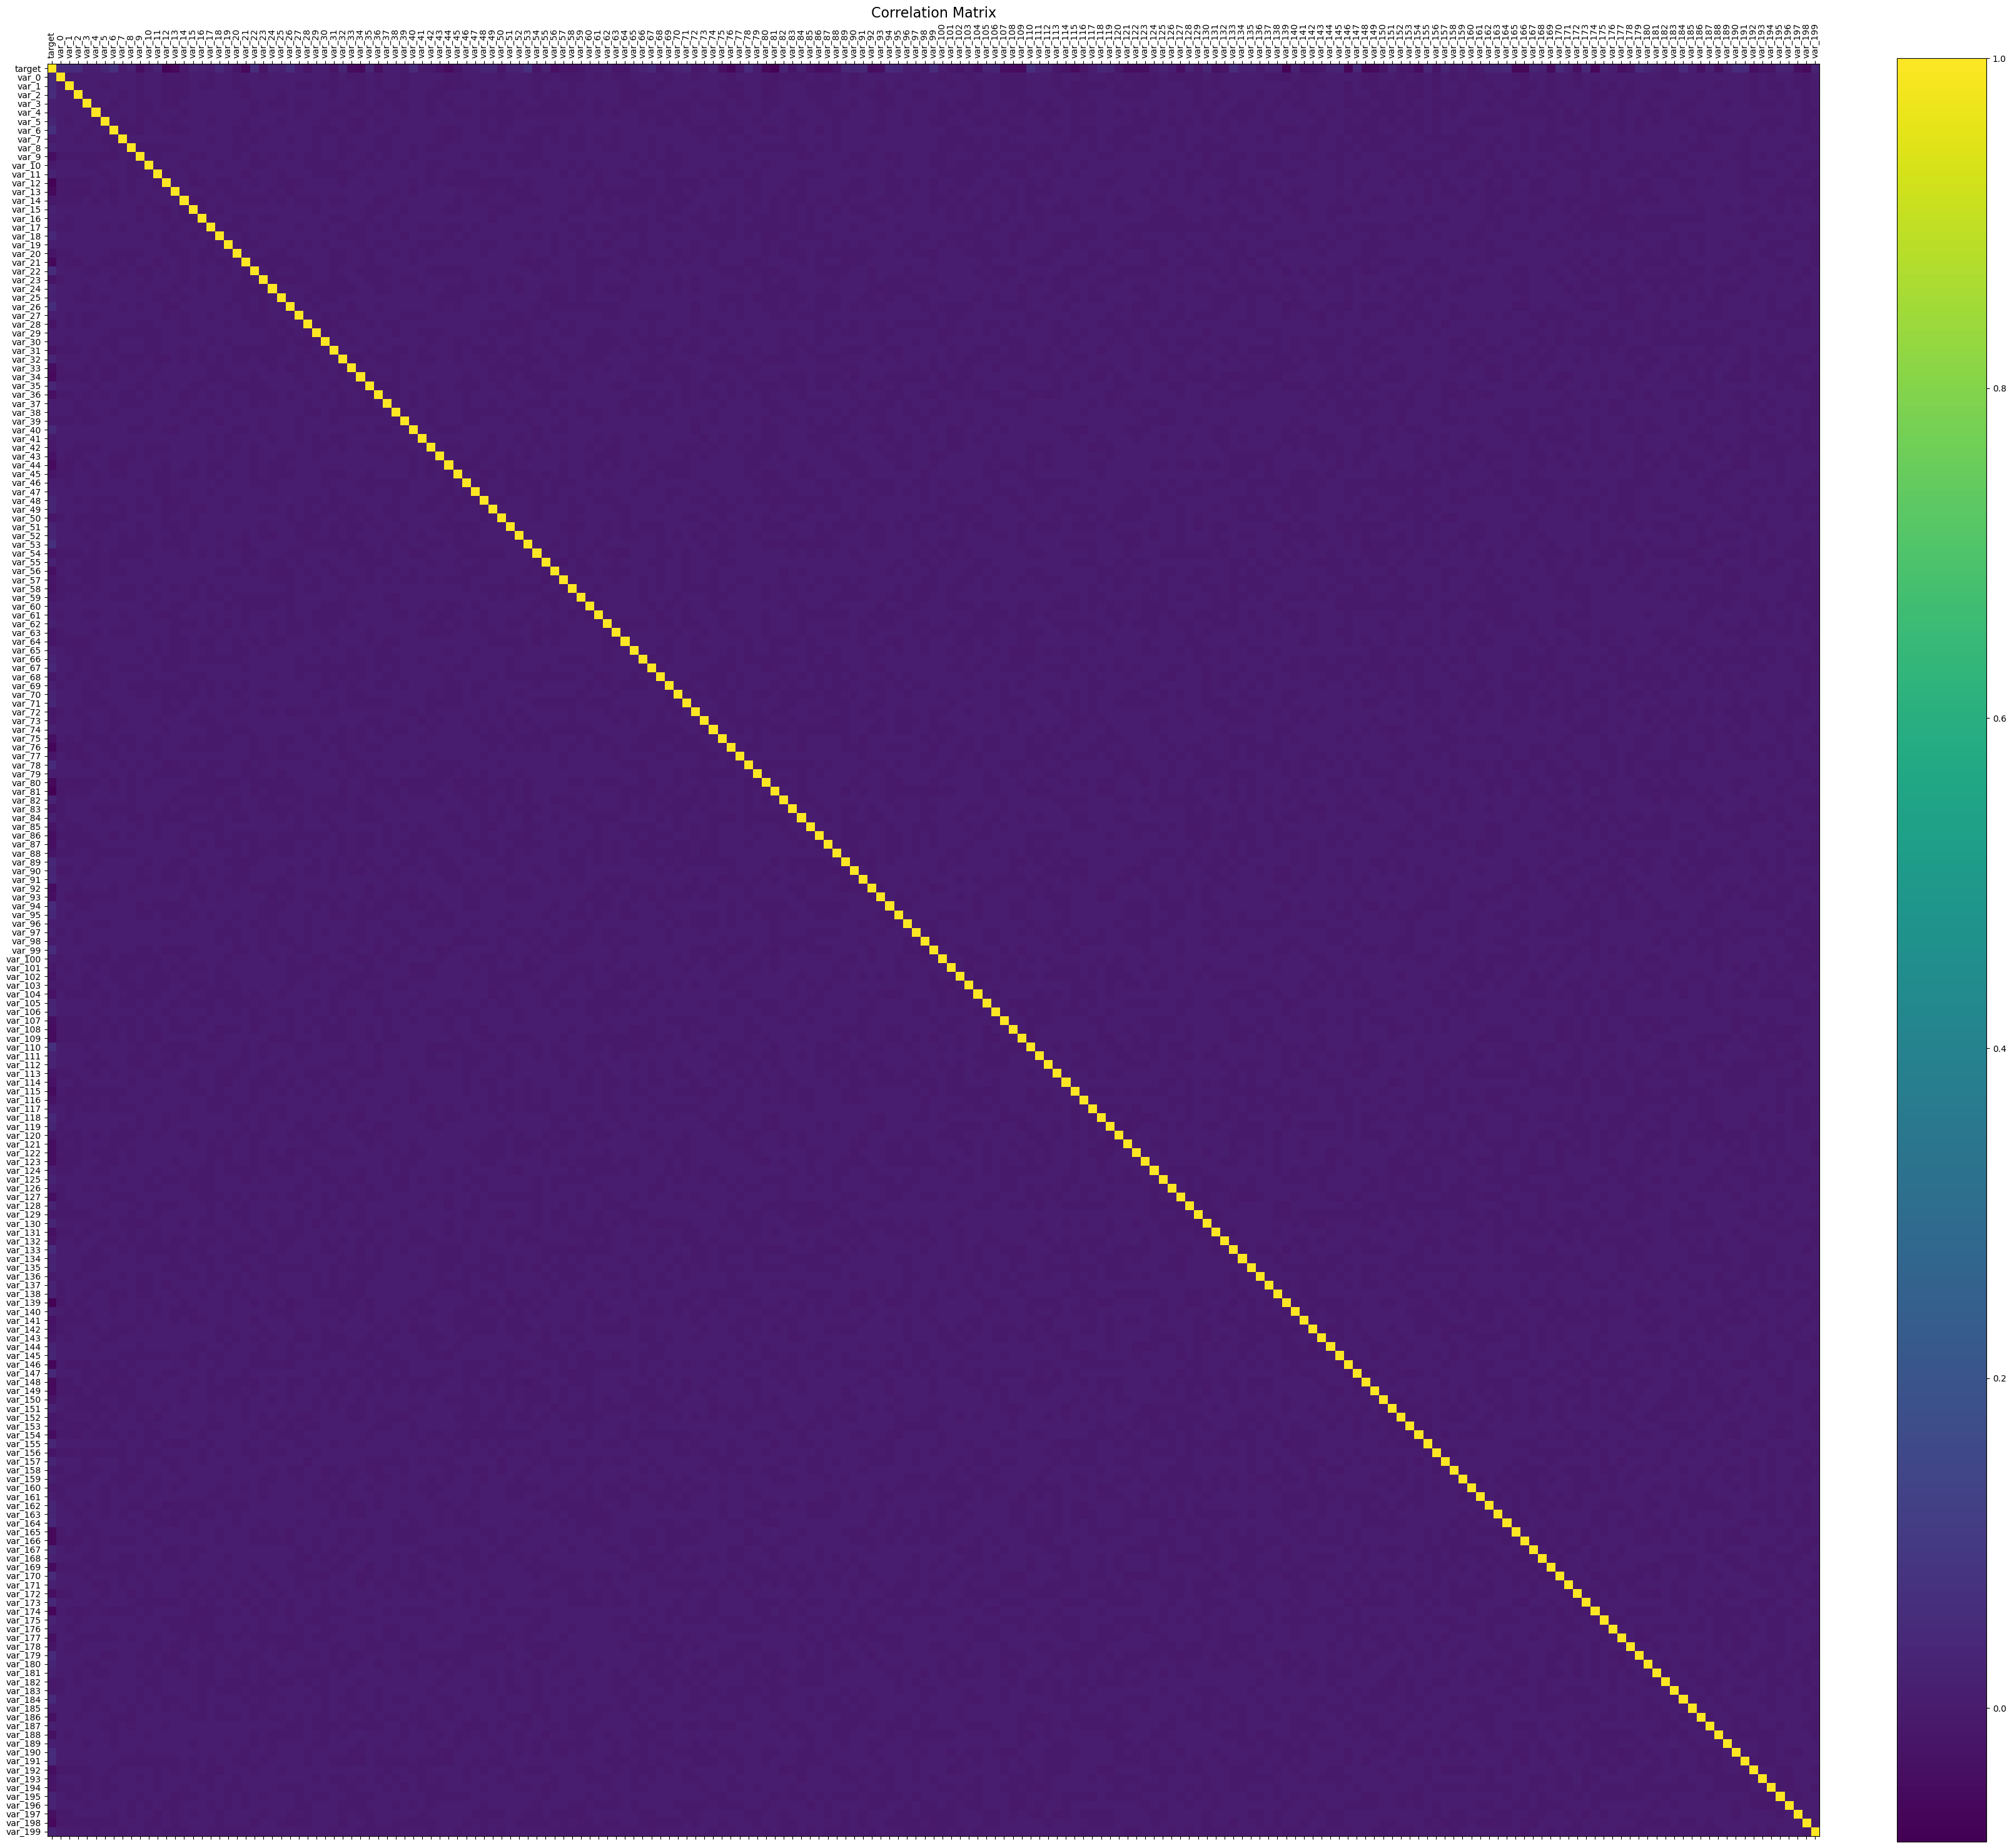

In [138]:
# 상관관계 분석
# 어차피 corr로 나오면 보기 힘드니 시각화하기
# 소스: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

f = plt.figure(figsize=(40, 40))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
plt.colorbar(fraction=0.046, pad = 0.04)
plt.title('Correlation Matrix', fontsize=16);

# 대각선은 항상 1(노랑색) 자기자신에 대한 상관관계이니까

# 근데 시각화를 해봤는데 대각선 제외하고는 다 보라색 나왔으니 별로 상관 없다는 뜻인듯...

# tip
# 만약 숫자가 아닌 값이 있다면 select_dtypes(['number']) 를 사용해서 숫자가있는 컬럼만 거를 수 있음
# As the df.corr() method ignores non-numerical columns, 
# .select_dtypes(['number']) should be used when defining the x and y labels 
# to avoid an unwanted shift of the labels (included in the code below).

# 데이터가 어떻게 분포되어있을까

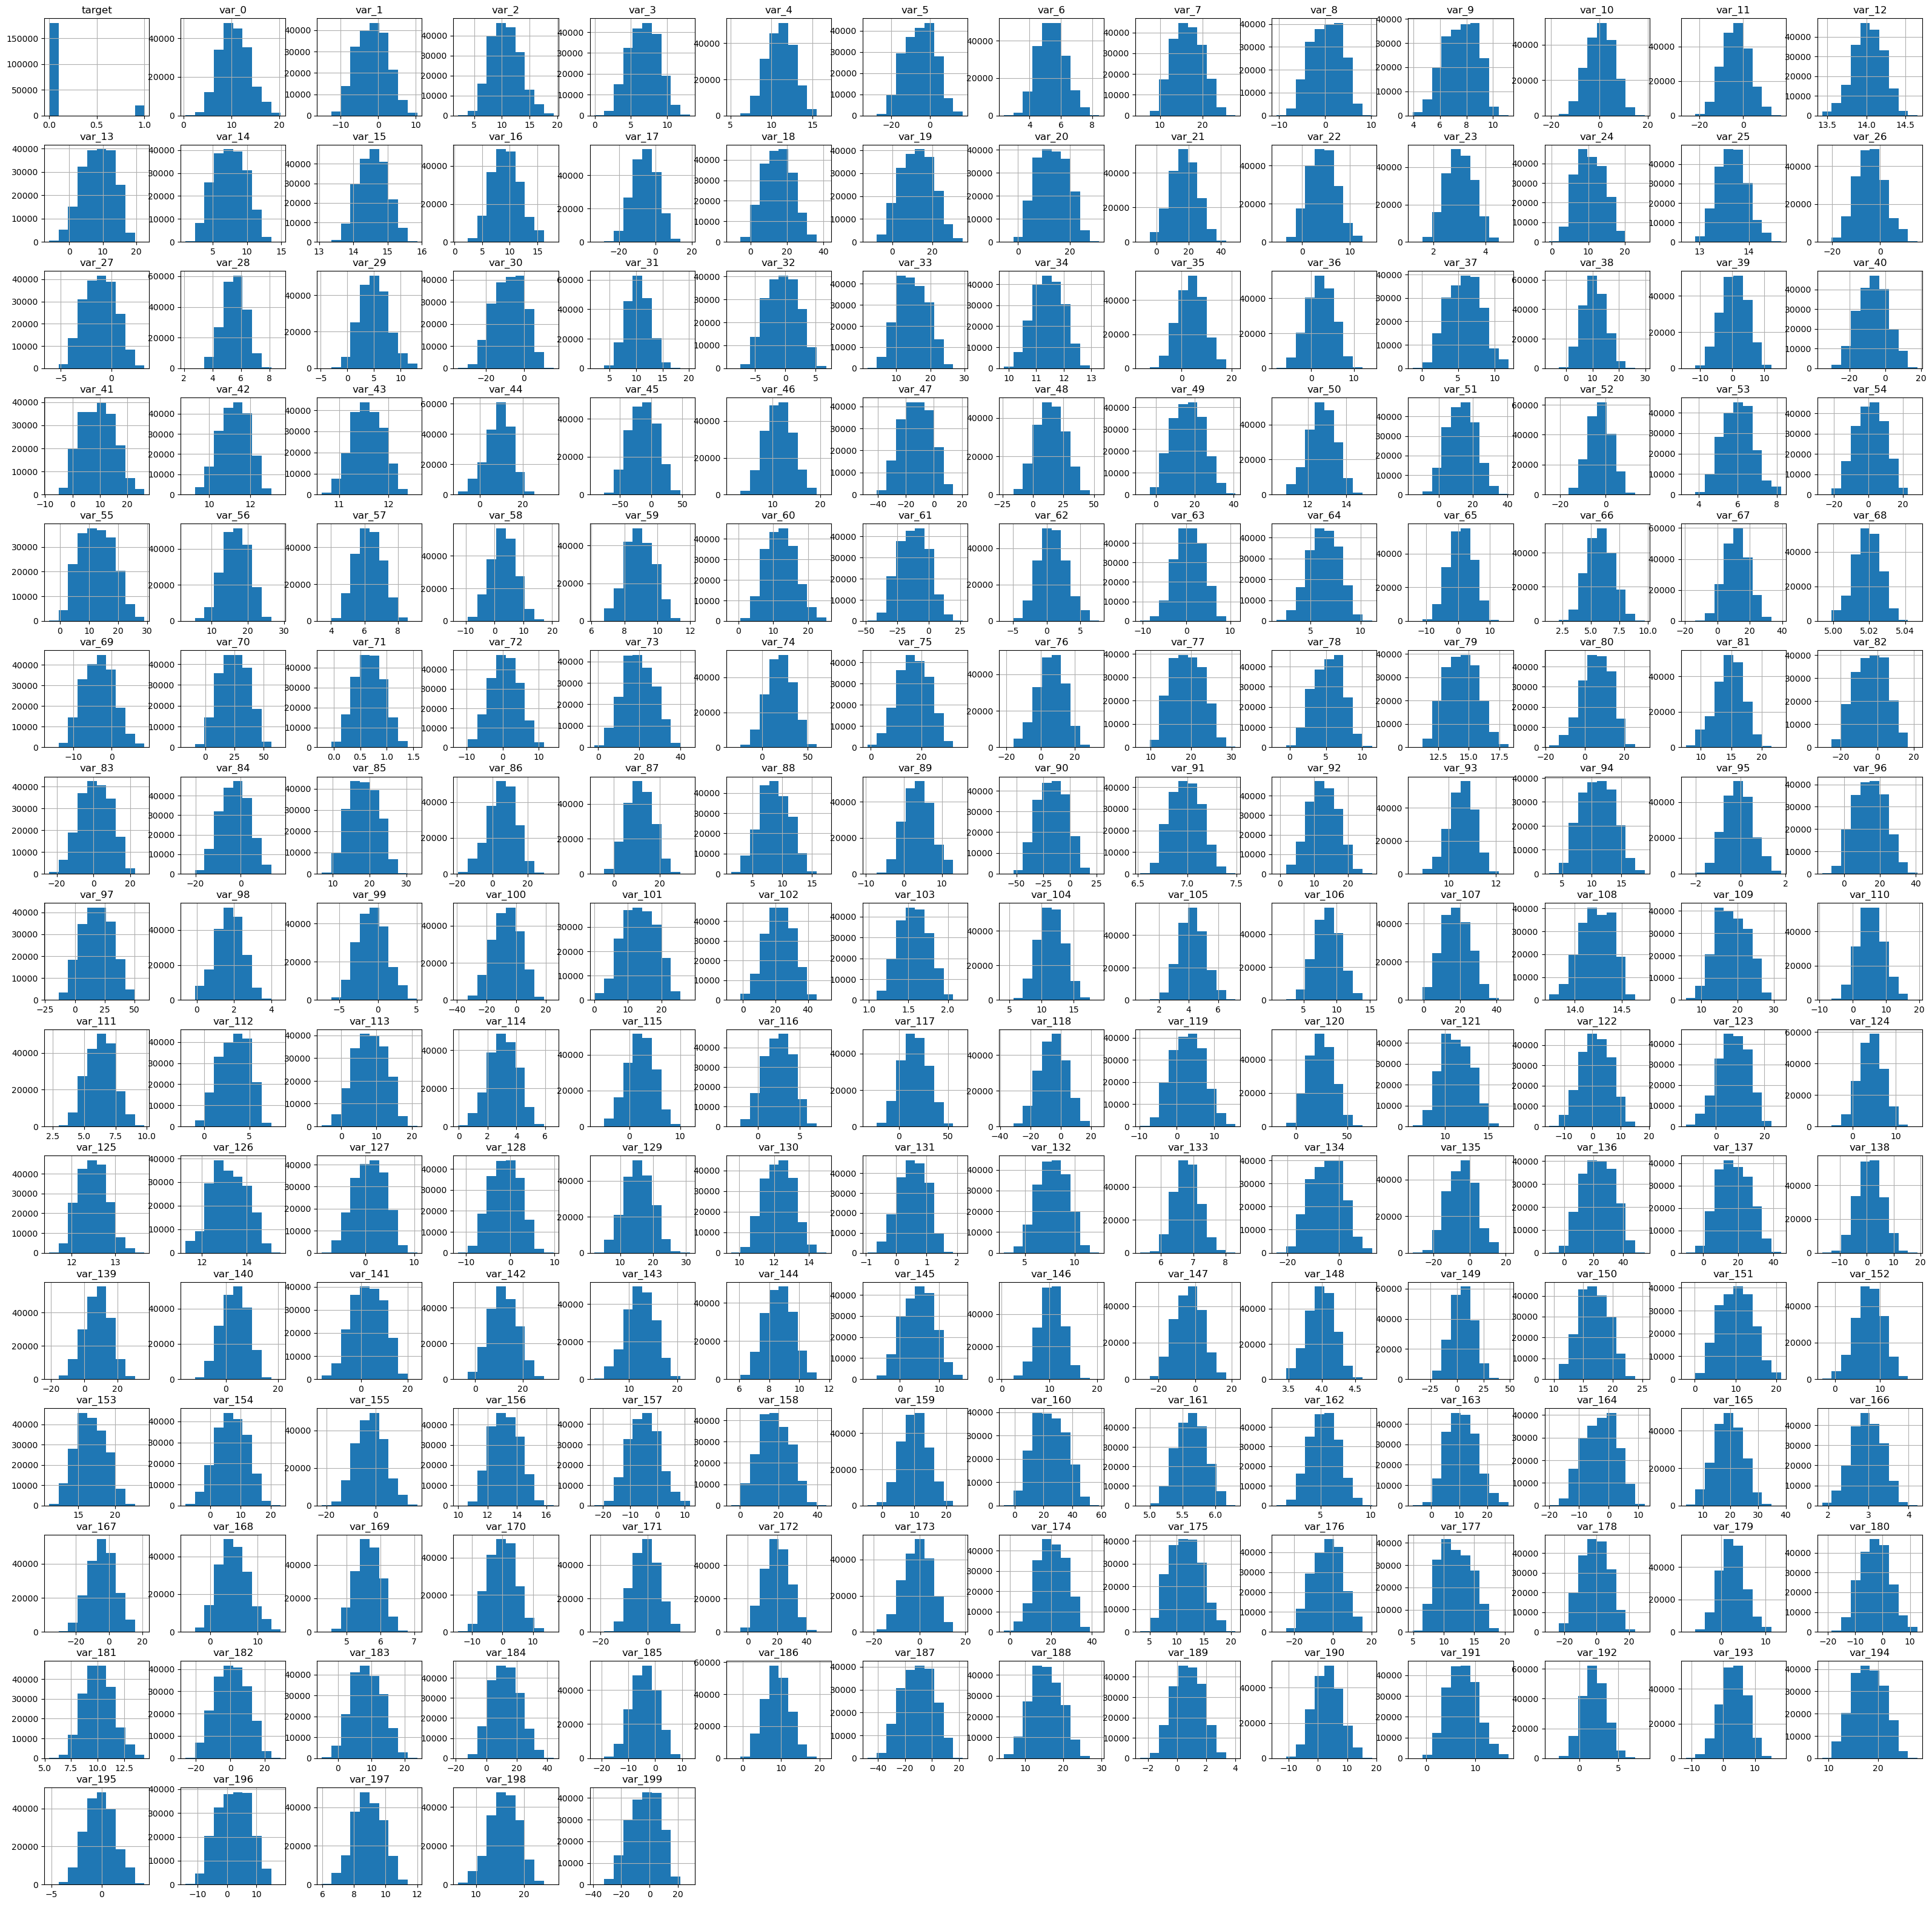

In [139]:
# 데이터가 어떻게 분포되어있는지?

df.hist(figsize=(40,40));

# LightGBM으로 독립변수 뽑기

[LightGBM] [Info] Number of positive: 20098, number of negative: 179902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100490 -> initscore=-2.191792
[LightGBM] [Info] Start training from score -2.191792


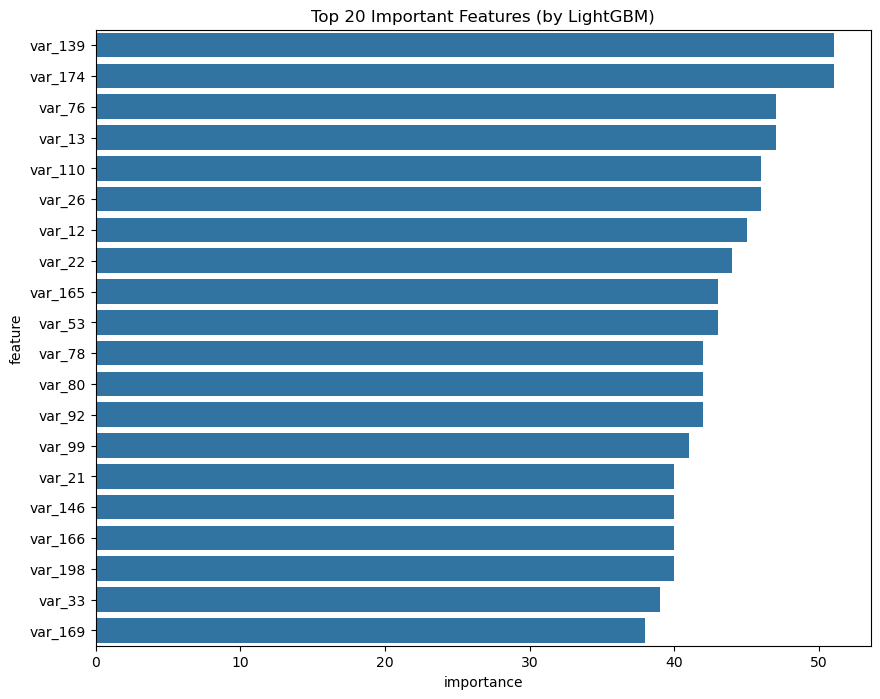

In [10]:
# LightGBM으로 중요한 변수 찾아보기:
#  LightGBM 모델을 사용해서 target을 예측하도록 학습,
# 그리고 그 과정에서 feature가 예측에 가장 많이 기여한 것 보여줌
# 정규화, 결측치, 이상치 자동 처리가 가능
X = df.drop(['target'], axis=1)
y = df['target']

model = LGBMClassifier(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_   # 나오는 수치는 feature를 x번 사용해서 분할했다는 것
}).sort_values(by='importance', ascending=False)

# 상위 20개 변수 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Important Features (by LightGBM)')
plt.show()

In [62]:
feature_importances.head(100)
# 보통 50 이상이면 많이 쓰이고, 10~50이면 써볼만한 수준
# 5 이하부터는 거의 안 씀
# 일단 30까지 뽑아봤는데 수가 완만하게 내려가는 형태이니, 10이상인 100개의 컬럼을 가져가자 

,feature,importance
139,var_139,51
174,var_174,51
76,var_76,47
13,var_13,47
110,var_110,46
...,...,...
52,var_52,10
111,var_111,10
114,var_114,10
186,var_186,10


In [63]:
top_features = feature_importances.sort_values(by='importance', ascending=False).head(100)['feature'].tolist()
print(top_features)

['var_139', 'var_174', 'var_76', 'var_13', 'var_110', 'var_26', 'var_12', 'var_22', 'var_165', 'var_53', 'var_78', 'var_80', 'var_92', 'var_99', 'var_166', 'var_198', 'var_21', 'var_146', 'var_33', 'var_169', 'var_2', 'var_34', 'var_44', 'var_1', 'var_123', 'var_190', 'var_40', 'var_164', 'var_148', 'var_81', 'var_6', 'var_179', 'var_0', 'var_147', 'var_170', 'var_109', 'var_133', 'var_9', 'var_94', 'var_149', 'var_122', 'var_127', 'var_56', 'var_86', 'var_67', 'var_108', 'var_91', 'var_177', 'var_75', 'var_115', 'var_18', 'var_184', 'var_107', 'var_121', 'var_191', 'var_89', 'var_36', 'var_154', 'var_118', 'var_5', 'var_87', 'var_35', 'var_173', 'var_172', 'var_155', 'var_119', 'var_95', 'var_188', 'var_197', 'var_93', 'var_192', 'var_106', 'var_180', 'var_157', 'var_141', 'var_130', 'var_49', 'var_131', 'var_51', 'var_162', 'var_43', 'var_150', 'var_48', 'var_145', 'var_163', 'var_167', 'var_90', 'var_32', 'var_135', 'var_71', 'var_125', 'var_151', 'var_195', 'var_70', 'var_137', 'va

In [64]:
# x_data.isnull().sum()
# df = df.dropna(axis=0)

x_data = df[top_features]
t_data = df['target']

#  OUTLIER 이상치 확인 & 처리

C:\Users\user\AppData\Local\Temp\ipykernel_20400\294182436.py:4: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df.boxplot(["var_139", "var_44", "var_36", "var_1", "var_109", "var_12", "var_33", "var_146"], by="target", grid=False, ax=ax);


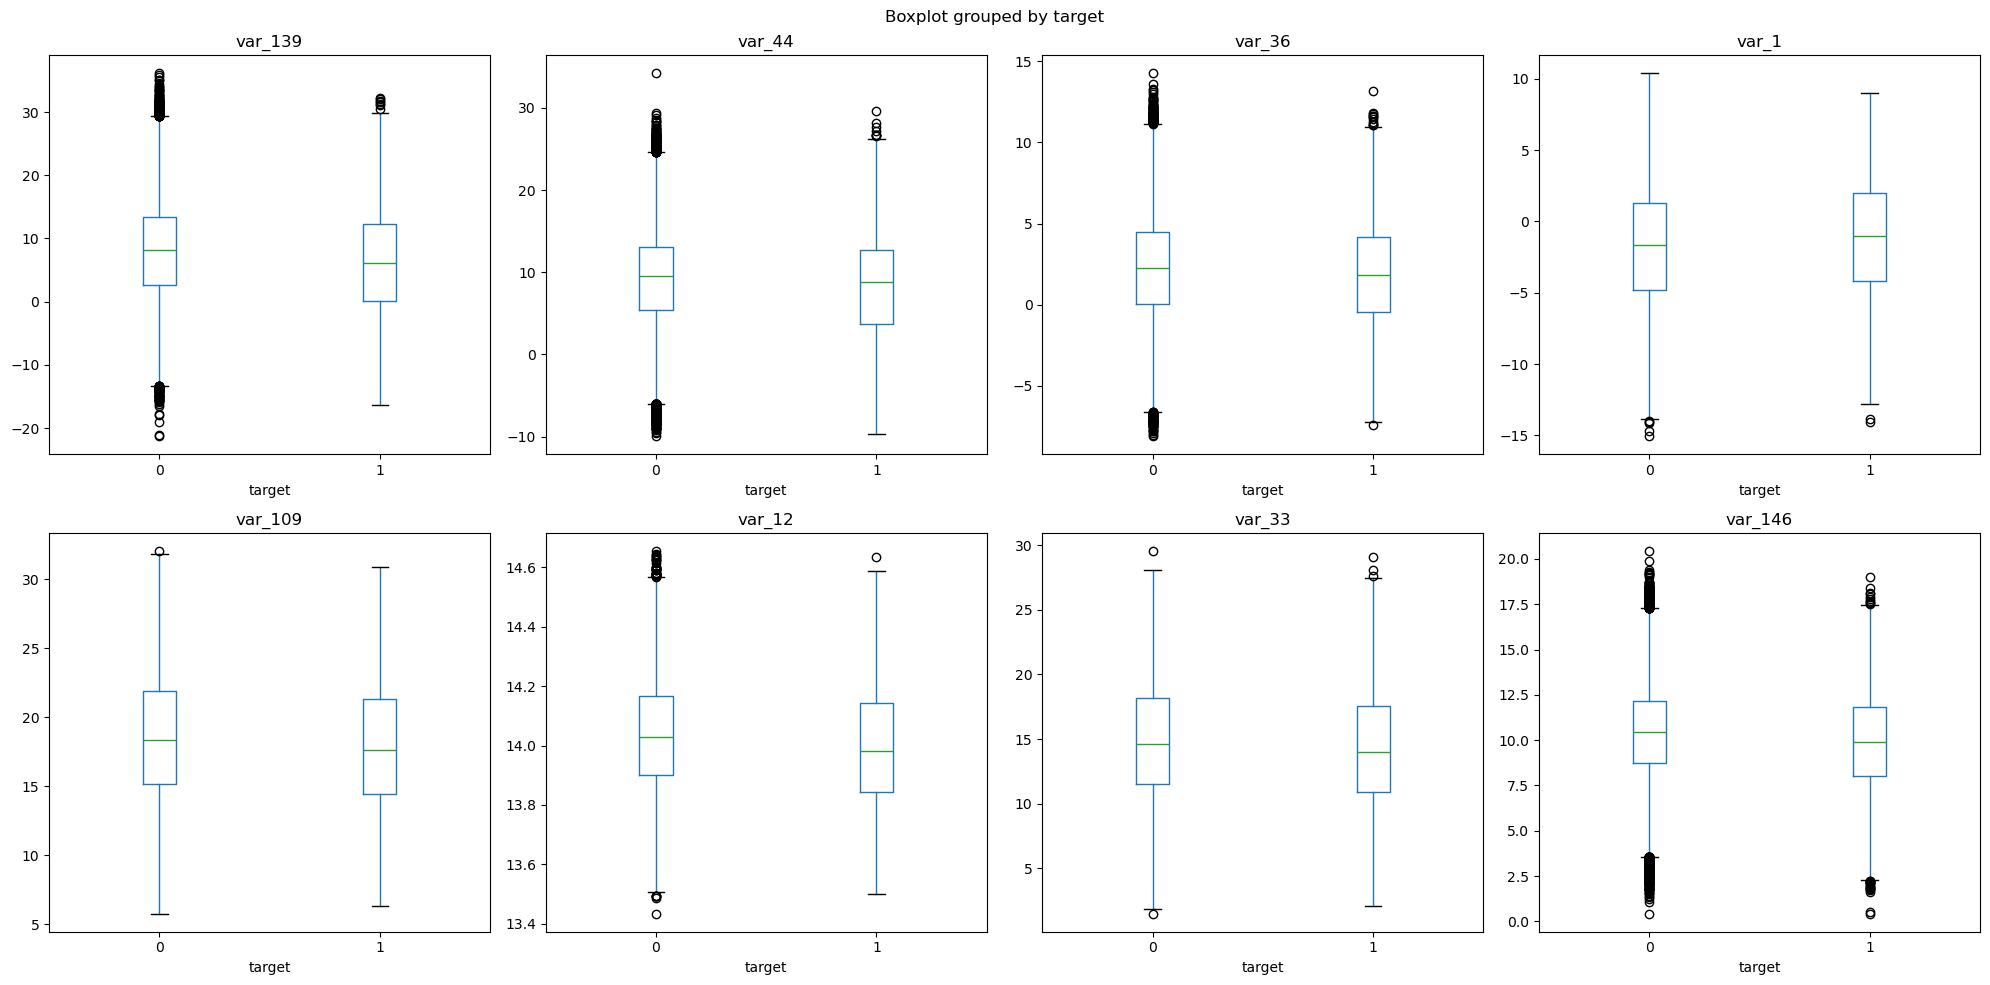

In [65]:
# 랜덤으로 확인...
fig, ax = plt.subplots(2,4,figsize=(20,10), sharey=False);

df.boxplot(["var_139", "var_44", "var_36", "var_1", "var_109", "var_12", "var_33", "var_146"], by="target", grid=False, ax=ax);

plt.tight_layout()
plt.show()

In [66]:
# std()  표준편차
# 각 독립변수의 표준편차를 구하고, 이상이나 이하인것을 idx에 넣음.
# 전체 데이터의 평균 ± 3 표준편차 안에 포함
#그 밖의 값들을 이상치(outlier) 로 본다는 의미
# 표준편차가 크면 데이터가 평균에 넓게 분포....

def identify_outliers(df):
  idx = []

  for col in df.columns:
      std = df[col].std()  # 각 독립변수의 표준편차 
      threshold = std * 3 
      idx_col = df[col][(df[col]>=abs(threshold)) | (df[col]<=-abs(threshold))].index.to_list()
      idx.append(idx_col)
  
  idx_flat = list(set([i for j in idx for i in j]))
    # 이상치 인덱를 뽑아서 set()으로 중복 제거후 리스트로 변환

  return idx_flat

In [67]:
outliers_idx = identify_outliers(x_data)
len(outliers_idx)

200000

In [69]:
# ? 이상치가 이만개가 나와서 안됨. 이러면 데이터 다 사라짐.

# Standardise_ 정규화

In [89]:
sc = StandardScaler()
df_norm = pd.DataFrame(sc.fit_transform(x_data))
df_norm["target"] = df["target"].copy()  # 정규화된 독립변수에 종속변수를 붙임...?
df_norm

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
0,1.027749,-0.231051,-1.057511,-1.714773,-0.910467,-0.184673,-0.054077,-0.606166,-1.323871,-1.091818,...,0.161129,-1.578117,-0.235063,1.551190,0.368029,0.413522,-0.565450,0.900016,1.270955,0
1,1.093098,1.408807,-0.350196,-0.025160,0.289561,-1.302434,-0.000409,1.491237,-0.832228,0.889088,...,1.194412,1.522342,1.348459,0.061194,-0.316814,0.732166,0.542635,-0.412563,-1.401648,0
2,0.118027,0.766677,-0.194760,-0.262491,-0.597095,-0.665103,0.888789,-1.085317,0.237541,0.519556,...,-0.538243,2.297370,-1.847904,-0.228441,0.653014,-0.562918,0.048517,-1.127290,0.699579,0
3,0.158970,-0.765424,0.710052,0.741492,-0.321857,0.822099,-0.934857,0.883010,-0.411123,-1.045397,...,1.775422,-0.789517,-1.706920,0.786554,0.866172,0.611970,-0.512477,-0.325002,0.789796,0
4,0.805903,-0.244125,-0.632825,-0.138103,-1.492695,1.220617,-0.925386,2.038227,0.387118,-0.330917,...,-2.231477,-0.958473,1.311677,0.922238,0.219058,-0.320771,-0.169872,-0.799239,-0.031910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2.075273,-1.241209,1.460172,-0.696630,-1.608487,1.175853,-0.199821,-1.128541,2.363325,0.233058,...,-0.500185,-1.155623,0.376799,0.306771,0.828984,0.557000,1.890624,-1.488196,-0.459515,0
199996,-0.902006,0.969076,1.003313,-1.125446,2.042549,1.567533,2.047378,-1.196380,-0.757151,-1.885540,...,-0.173364,1.312319,-0.152381,0.000185,1.874652,0.925440,0.982256,-0.840089,0.407299,0
199997,-0.872643,1.652445,-1.290658,0.261054,-0.531888,1.520118,-0.770697,-0.422981,2.471821,0.089612,...,0.037214,-1.001499,0.096906,0.556004,-0.639128,2.288890,-0.760702,0.726272,0.177911,0
199998,-0.718735,-1.589073,1.058790,-0.423779,-0.681133,0.113004,0.984023,0.447645,1.302115,0.303146,...,-0.485144,0.044417,-0.029888,-1.549369,0.712085,0.130633,0.345049,1.098275,0.378600,0


# DownSampling

In [90]:
# 타겟 0인 데이터 중에서 target 1인 데이터 갯수만큼 랜덤 샘플링함
df_ds = df_norm[df_norm["target"] == 0].sample(n=df_norm[df_norm["target"] == 1].shape[0], random_state=42)
df_1 = df_norm[df_norm["target"] == 1]  # 1만 뽑고

df_downsampled = pd.concat([df_1, df_ds], ignore_index=True) # 둘이 붙임...
df_downsampled['target'].value_counts()

target
1    20098
0    20098
Name: count, dtype: int64

# 데이터 분리

In [91]:
X = df_downsampled.drop("target", axis=1)
Y = df_downsampled["target"]

# 모델링

### Cross-Validation
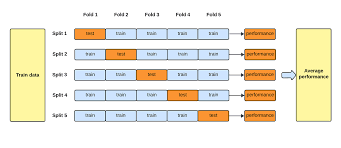

### GaussianNB  가우시안 나이브 베이즈
- 각 피처(변수)가 정규분포(가우시안 분포) 를 따른다고 가정하고 작동하는 모델
- 학습 방식:	각 클래스 별로 평균과 분산 계산 → 새로운 데이터가 들어오면 확률 비교해서 분류
- 데이터가 피처 간 독립에 가까울 때 쓰면 좋음?(독립변수끼리 서로 영향을 안 미침)
- 상관계수가 낮을 때 유리

⚠️ 주의할 점
- 피처 간 상관관계가 크거나, 정규분포가 아닌 경우 성능이 떨어질 수 있음
- 아주 복잡한 문제에서는 성능이 단순 모델 수준

In [73]:
np.random.seed(42)

models = {"Logistic Regression":LogisticRegression(),
          "Random Tree Classifier":RandomForestClassifier(),
          "Gaussian Naive Bayes":GaussianNB()   # 가우시안 나이브 베이즈
         }
results = dict()

for model in models:
  print("Fitting {}...".format(model), end = " ")
  scores = cross_val_score(models[model], X, Y, cv=10, scoring = "roc_auc", n_jobs = -1)
  results[model] = scores
  score = scores.mean()
  print("Done! Mean AUC score: {}".format(score))

# Fitting Logistic Regression... Done! Mean AUC score: 0.8465932608107456
# Fitting Random Tree Classifier... Done! Mean AUC score: 0.825256885560977
# Fitting Gaussian Naive Bayes... Done! Mean AUC score: 0.8762234418397575

Fitting Logistic Regression... Done! Mean AUC score: 0.8465932608107456
Fitting Random Tree Classifier... Done! Mean AUC score: 0.825256885560977
Fitting Gaussian Naive Bayes... Done! Mean AUC score: 0.8762234418397575


# Training 
- Gaussian Naive Bayes가 가장 점수가 높으니 사용

In [92]:
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(X, 
                 Y, 
                 random_state=42, 
                 test_size=0.2)

gnb = GaussianNB()
gnb.fit(x_data_train, t_data_train)

GaussianNB()

# Testing

In [93]:
pred_test = gnb.predict(x_data_test)  # 예측값
print("Test AUC: {}".format(roc_auc_score(t_data_test, pred_test)))
print(classification_report(t_data_test, pred_test))
print("\n")

# Test AUC: 0.7924048236712401
#               precision    recall  f1-score   support

#            0       0.79      0.79      0.79      4049
#            1       0.79      0.79      0.79      3991

#     accuracy                           0.79      8040
#    macro avg       0.79      0.79      0.79      8040
# weighted avg       0.79      0.79      0.79      8040

Test AUC: 0.7924048236712401
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4049
           1       0.79      0.79      0.79      3991

    accuracy                           0.79      8040
   macro avg       0.79      0.79      0.79      8040
weighted avg       0.79      0.79      0.79      8040





# 일단 test 데이터를 넣어보자

In [74]:
# 1. raw data loading
test = pd.read_csv('C:/education/pythonedu/MoonExercise/CustomerTransaction/testCT.csv')

t = test[top_features]
t.head()

,var_139,var_174,var_76,var_13,var_110,var_26,var_12,var_22,var_165,var_53,...,var_125,var_151,var_195,var_70,var_137,var_52,var_111,var_114,var_186,var_132
0,-2.5502,18.1317,7.3075,0.3458,3.7662,-9.4902,13.9696,1.5899,22.9530,7.3213,...,12.4929,9.8892,2.4669,33.3401,17.7547,-4.8525,6.0426,2.0921,9.2874,10.5998
1,6.7530,10.5018,6.9388,2.5667,1.7375,-5.2341,14.1129,5.2578,15.5134,6.8481,...,12.0099,9.3783,0.4773,12.2806,4.8775,1.5776,5.5689,4.1159,11.8263,9.7974
2,-6.0452,27.4035,-9.7077,3.8183,8.6896,-15.4246,13.6751,4.7473,13.3009,5.6510,...,12.6482,14.1649,2.1281,19.2081,6.8031,-0.6434,8.1036,0.9777,4.9178,7.7726
3,12.7898,14.5499,12.5465,13.5010,10.3445,1.0061,14.0526,2.9707,24.8712,6.2536,...,12.0067,9.7908,3.1656,8.9289,12.6907,-4.1185,6.0369,2.1278,3.3102,4.7666
4,11.7989,14.0037,8.1522,8.9672,6.3933,8.6228,14.1013,6.7954,26.2040,5.6794,...,12.7157,6.9953,-0.2860,39.8219,23.5997,-0.1543,6.8699,3.2376,8.3635,7.1984


In [116]:
test

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122


In [132]:
# 정규화
test_norm = sc.transform(t)

In [133]:
# 모델...
res = gnb.predict(test_norm[0].reshape(1, -1))
res

array([1], dtype=int64)

In [135]:
# for문은 오래 걸리니 웬만해서는 쓰지 말기
preds = gnb.predict(test_norm)

# 결과 저장
my_ans200 = pd.DataFrame({
    'ID_code': [f'test_{i}' for i in range(len(test))],
    'target': preds
})

display(my_ans)

,ID_code,target
0,test_0,1
1,test_1,1
2,test_2,1
3,test_3,0
4,test_4,0
...,...,...
199995,test_199995,0
199996,test_199996,0
199997,test_199997,0
199998,test_199998,0


In [136]:
my_ans200['target'].value_counts()
# my_ans.shape

target
0    148427
1     51573
Name: count, dtype: int64

In [137]:
my_ans.to_csv("GNB_CustomerTransaction.csv", index=False)

In [111]:
from IPython.display import FileLink

# Create a link to the file
FileLink(r'GNB_CustomerTransaction.csv')

c:\education\pythonedu\MoonExercise\CustomerTransaction\GNB_CustomerTransaction.csv

# 결과
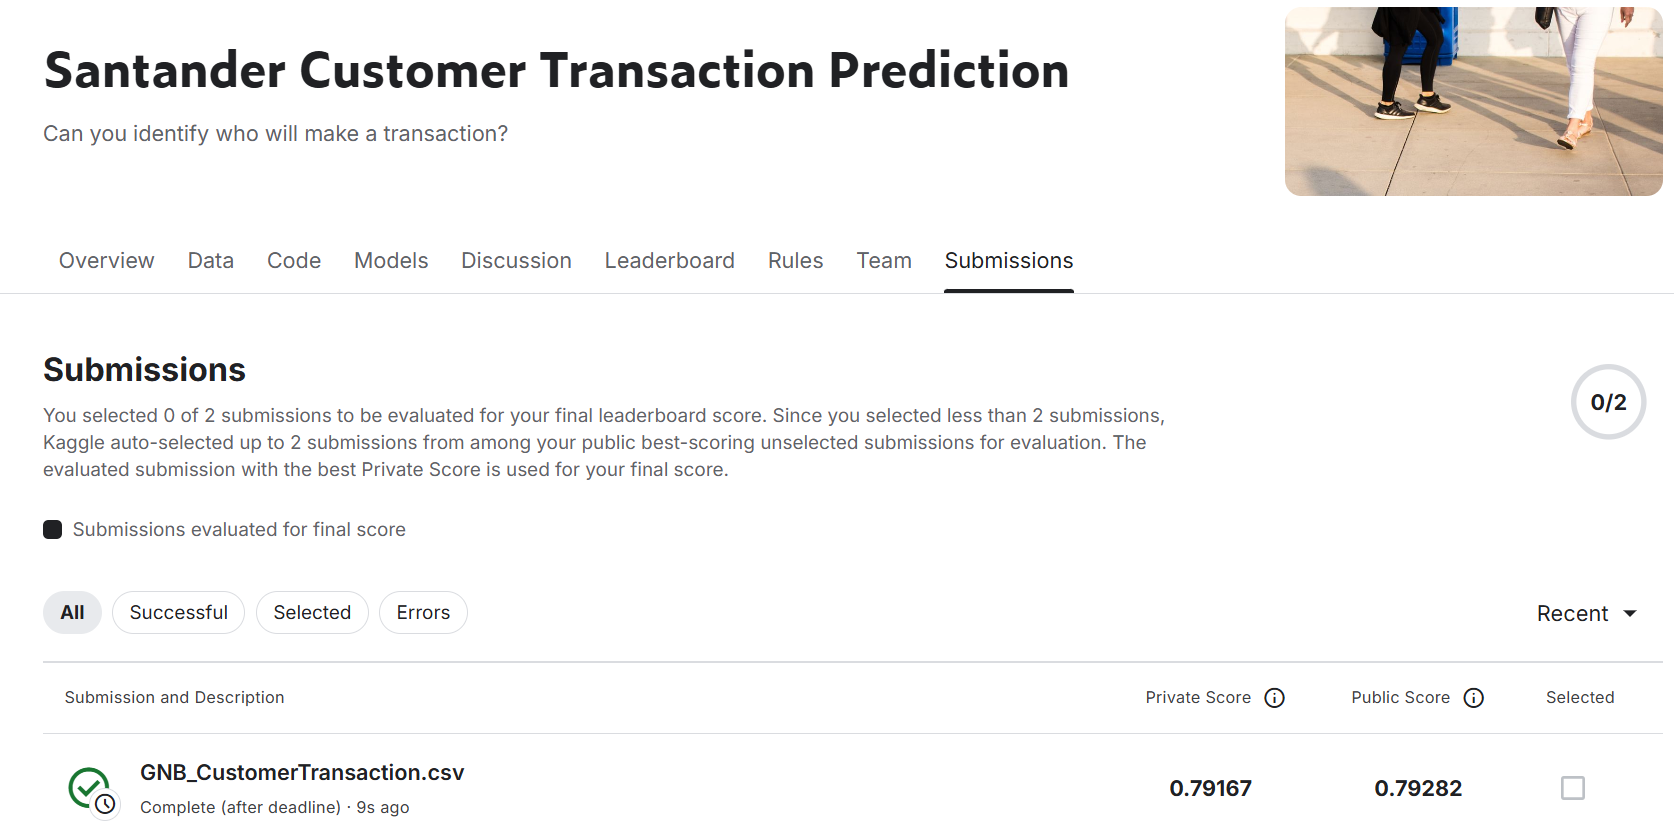